<a href="https://colab.research.google.com/github/YangxuanWu/Python/blob/master/FinallProject2020/FallProject2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Connect to my google drive

In [4]:
#1
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/")

Mounted at /content/drive


#Data cleansing

2 Original data(CICIDS2017) becomes Total_Attack.csv

In [ ]:
#2
##  CICIDS2017 csv files are required for the operation of the program.
##  These files must be located under the "CSVs" folder in the same directory as the program.
##  The purpose of this program is to clear the csv files containing CICIDS2017 data from errors.
##  the faults observed are:
##      1-   288602 of the entries in the file "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv" are empty / meaningless.
##                   (e.g. ",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,")
##
##      2-  In the original csv files, while describing the Web Attack types such as Brute Force, XSS, Sql Injection, the character used is not recognized
##                    by the Python-Pandas library and leads to the error.
##                    this character ("–", Unicode code:8211) has been changed with another character ("-", Unicode code:45) to correct the error.
##
##   After the error correction, all the csv files were made into a single file (Total_Attack.csv) to make it easier to process.

import pandas as pd
import os
from sklearn import preprocessing
import time
seconds = time.time()
%matplotlib inline

print("This process may take 5 to 10 minutes, depending on the performance of your computer.\n\n\n")
number="0123456789"
# CSV files names:
csv_files=["Monday-WorkingHours.pcap_ISCX",
        "Tuesday-WorkingHours.pcap_ISCX",
        "Wednesday-workingHours.pcap_ISCX",
        "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX",
        "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX",
        "Friday-WorkingHours-Morning.pcap_ISCX",
        "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX",
        "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX"]

# Headers of column
main_labels=["Flow ID","Source IP","Source Port","Destination IP","Destination Port","Protocol","Timestamp","Flow Duration","Total Fwd Packets",
   "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","faulty-Fwd Header Length","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min","Idle Mean","Idle Std","Idle Max","Idle Min","Label","External IP"]

main_labels2=main_labels
main_labels=( ",".join( i for i in main_labels ) )
main_labels=main_labels+"\n"
flag=True
for i in range(len(csv_files)):
    ths = open(str(i)+".csv", "w")
    ths.write(main_labels)
    with open("./CSVs/"+csv_files[i]+".csv", "r", encoding='cp1252') as file:
        while True:
            try:
                line=file.readline()
                if  line[0] in number:# This line eliminates headers from CSV files and incomplete streams
                    if u"\u2013" in str(line): ##  If there is a "-" character in the stream (Unicode code :8211), 
                                    #it will be adjacent to the "-" character (Unicode code :45)
                        line=(str(line).replace(u"\u2013","-"))
                    ths.write(str(line))
                else:
                    continue                       
            except:
                break
    ths.close()
 
 
    df=pd.read_csv(str(i)+".csv",low_memory=False)
    df=df.fillna(0)

    string_features=["Flow Bytes/s","Flow Packets/s"]
    for ii in string_features: #Some of the data in the Stream Byte/s and Stream Packet/s columns are not numbers. Fix bugs in this loop
        df[ii]=df[ii].replace('Infinity', -1)
        df[ii]=df[ii].replace('NaN', 0)
        number_or_not=[]
        for iii in df[ii]:
            try:
                k=int(float(iii))
                number_or_not.append(int(k))
            except:
                number_or_not.append(iii)
        df[ii]=number_or_not



    string_features=[]
    for j in main_labels2: # Detects non-numeric (string and/or classification) attributes (columns).
        if df[j].dtype=="object":
            string_features.append(j)
    try:
        string_features.remove('Label')#The "Label" attribute is removed from the list. Because it has to maintain a "taxonomy" of different machine learning methods.
    except:
        print("error!")
    labelencoder_X = preprocessing.LabelEncoder()



    for ii in string_features: ## In this loop, non-numeric (string and/or classification) attributes are converted to numeric attributes.
        try:
            df[ii]=labelencoder_X.fit_transform(df[ii])
        except:
            df[ii]=df[ii].replace('Infinity', -1)
    df=df.drop(main_labels2[61], axis=1) ## Column 61 was deleted because it was unnecessary, and column 41 (the "Fwd head length" feature) was incorrectly overridden.



    ##All CSV files are merged into a single file.
    if flag:
        df.to_csv('Total_Attack.csv' ,index = False)
        flag=False
    else:
        df.to_csv('Total_Attack.csv' ,index = False,header=False,mode="a")
    os.remove(str(i)+".csv")
    print("The pre-processing phase of the ",csv_files[i]," file is completed.\n")
    

print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")


This process may take 5 to 10 minutes, depending on the performance of your computer.



The pre-processing phase of the  Monday-WorkingHours.pcap_ISCX  file is completed.

The pre-processing phase of the  Tuesday-WorkingHours.pcap_ISCX  file is completed.

The pre-processing phase of the  Wednesday-workingHours.pcap_ISCX  file is completed.

The pre-processing phase of the  Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX  file is completed.

The pre-processing phase of the  Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX  file is completed.

The pre-processing phase of the  Friday-WorkingHours-Morning.pcap_ISCX  file is completed.

The pre-processing phase of the  Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX  file is completed.

The pre-processing phase of the  Friday-WorkingHours-Afternoon-DDos.pcap_ISCX  file is completed.

mission accomplished!
Total operation time: =  235.25334811210632 seconds


3 Data presentation by matplotlib

BENIGN                        2359289
DoS Hulk                       231073
PortScan                       158930
DDoS                            41835
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack - Brute Force         1507
Web Attack - XSS                  652
Infiltration                       36
Web Attack - Sql Injection         21
Heartbleed                         11
Name: Label, dtype: int64


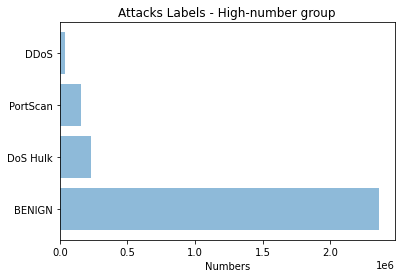

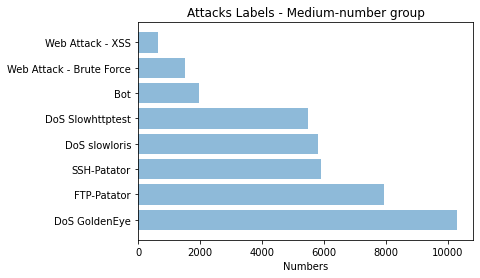

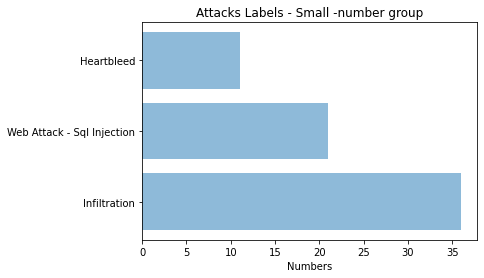

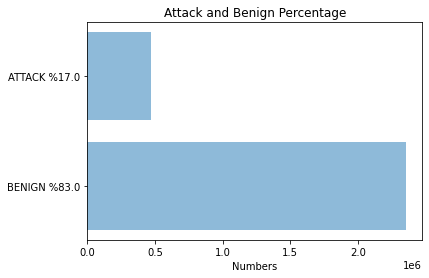

mission accomplished!
Total operation time: =  11.137970209121704 seconds


In [ ]:
##3.  Total_Attack.csv files is required for the operation of the program.
## Total_Attack.csv file must be located in the same directory as the program. 
##  In the last graphics, the rates of all attacks and normal behaviors are given.

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
%matplotlib inline
import time
seconds = time.time()

#  Graph creation function
def graph(objects,performance,x_label,y_label):
    y_pos = np.arange(len(objects))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel(x_label)
    plt.title(y_label)
    plt.show()

df=pd.read_csv('Total_Attack.csv', usecols=["Label"])
print(df.iloc[:,0].value_counts())
a=(df.iloc[:,0].value_counts())

key=a.keys()
values=a.values
small_labels=[]
small_values=[]
big_labels=[]
big_values=[]
medium_labels=[]
medium_values=[]
attacak=0
benign=0

## In this section, the attacks are divided into three groups，
##So that you can see all the values in the diagram.
for i in range(0,len(values)):
    if values[i]>11000:
        big_labels.append(str(key[i]))
        big_values.append(values[i])
    elif values[i]<600:
        small_labels.append(str(key[i]))
        small_values.append(values[i]) 
    else:
        medium_labels.append(str(key[i]))
        medium_values.append(values[i])

    if str(key[i])=="BENIGN":
        benign+=values[i]
    else:
        attacak+=values[i]
        
key =[benign,attacak]


#The function is called to create a feature
labels=["BENIGN %"+str(round(benign/(benign+attacak),2)*100),
        "ATTACK %"+str(round(attacak/(benign+attacak),2)*100)]
graph(big_labels,big_values,"Numbers","Attacks Labels - High-number group")
graph(medium_labels,medium_values,"Numbers","Attacks Labels - Medium-number group")
graph(small_labels,small_values,"Numbers","Attacks Labels - Small -number group")
graph(labels,key,"Numbers","Attack and Benign Percentage")



print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")

4 Create each attack to become a data with 20% attack and 80% benign

In [ ]:
#4
##The Total_Attack.csv file must be located in the same directory as the program. 
##The purpose of the program is to generate a CSV file containing only one type of attack and benign flow. 
#These files contain all attack flows and some benign data flow incidence (attack = 20%, benign =80%). The normal data flow is randomly selected

import random
import os
import pandas as pd
import time
seconds = time.time()
%matplotlib inline

def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")
        


print("This process may take 3 to 8 minutes, depending on the performance of your computer.\n\n\n")




# Headers of column
main_labels=["Flow ID","Source IP","Source Port","Destination IP","Destination Port","Protocol","Timestamp","Flow Duration","Total Fwd Packets",
   "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min","Idle Mean","Idle Std","Idle Max","Idle Min","Label","External IP"]
main_labels=( ",".join( i for i in main_labels ) )

attacks=["BENIGN", "Bot", "DDoS", "DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris", "FTP-Patator", "Heartbleed", "Infiltration", "PortScan", "SSH-Patator", "Web Attack – Brute Force", "Web Attack – Sql Injection", "Web Attack – XSS"]
folder("./attacks/")

benign=2359289

dict_attack={
"Bot":1966,
"DDoS":41835,
"DoS GoldenEye":10293,
"DoS Hulk":231073,
"DoS Slowhttptest":5499,
"DoS slowloris":5796,
"FTP-Patator":7938,
"Heartbleed":11,
"Infiltration":36,
"PortScan":158930,
"SSH-Patator":5897,
"Web Attack - Brute Force":1507,
"Web Attack - XSS":652,
"Web Attack - Sql Injection":21}



for i in dict_attack: # Open a file for each type of attack and record it in a random benign flow.
    a,b=0,0
    ths = open("./attacks/"+i + ".csv", "w")
    ths.write(str(main_labels)+"\n")
    benign_num=int(benign/(dict_attack[i]*(8/2)))
    with open("Total_Attack.csv", "r") as file:
        while True:
            try:
                line=file.readline()
                line=line[:-1]##Remove the last character (newline) of this line of text, and the rest
                k=line.split(",")
                
                if k[83]=="BENIGN":
                    rnd=random.randint(1,benign_num)
                    if rnd==1:
                      ths.write(str(line)+"\n")
                      b+=1

                if k[83]==i:
                  ths.write(str(line)+"\n")
                  a+=1
                else:
                
                    continue                       
            except:
                break
    ths.close()
    print(i ,"file is completed\n attack:%d\n benign:%d\n\n\n " %(a,b))

##All web attack files are merged into a single file.
webs=["Web Attack - Brute Force","Web Attack - XSS","Web Attack - Sql Injection"]
flag=True
for i in webs:
    df=pd.read_csv("./attacks/"+str(i)+".csv")
    if flag:
        df.to_csv('./attacks/Web Attack.csv' ,index = False)
        flag=False
    else:
        df.to_csv('./attacks/Web Attack.csv' ,index = False,header=False,mode="a")
    os.remove("./attacks/"+str(i)+".csv")


print("mission accomplished!")
print("operation time: = ",time.time() - seconds ,"seconds")    


This process may take 3 to 8 minutes, depending on the performance of your computer.



Bot file is completed
 attack:1966
 benign:7822


 
DDoS file is completed
 attack:41835
 benign:168840


 
DoS GoldenEye file is completed
 attack:10293
 benign:41288


 
DoS Hulk file is completed
 attack:231073
 benign:1179763


 
DoS Slowhttptest file is completed
 attack:5499
 benign:22438


 
DoS slowloris file is completed
 attack:5796
 benign:23311


 
FTP-Patator file is completed
 attack:7938
 benign:31884


 
Heartbleed file is completed
 attack:11
 benign:35


 
Infiltration file is completed
 attack:36
 benign:117


 
PortScan file is completed
 attack:158930
 benign:786442


 
SSH-Patator file is completed
 attack:5897
 benign:23601


 
Web Attack - Brute Force file is completed
 attack:1507
 benign:6074


 
Web Attack - XSS file is completed
 attack:652
 benign:2674


 
Web Attack - Sql Injection file is completed
 attack:21
 benign:88


 
mission accomplished!
operation time: =  235.

#Features selection

5 Calulate the importance weight of the feature in each attack file and find the most improtant features for each attack

Bot importance list:
Bot 
                              importance
Features                               
Bwd Packet Length Mean         0.076380
Total Length of Bwd Packets    0.036919
Bwd Packet Length Max          0.035601
Flow Duration                  0.019469
Total Backward Packets         0.018648
Bwd Packet Length Min          0.017157
Flow IAT Max                   0.016421
Bwd Packet Length Std          0.015995
Flow IAT Mean                  0.013592
Flow Bytes/s                   0.012953
Total Length of Fwd Packets    0.012719
Flow IAT Std                   0.012417
Flow Packets/s                 0.011753
Flow IAT Min                   0.010290
Fwd Packet Length Min          0.008887
Fwd IAT Total                  0.007348
Total Fwd Packets              0.006312
Fwd Packet Length Mean         0.004007
Fwd Packet Length Max          0.003627
Fwd Packet Length Std          0.002962 



Bot=["Bwd Packet Length Mean","Total Length of Bwd Packets","Bwd Packet Length Max","Flow

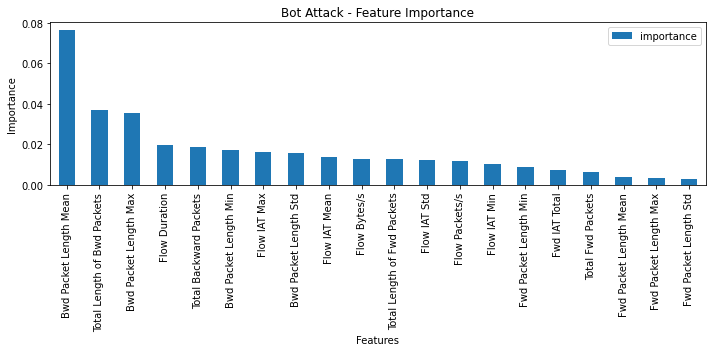

-----------------------------------------------------------------------------------------------




DDoS importance list:
DDoS 
                              importance
Features                               
Bwd Packet Length Mean         0.051853
Bwd Packet Length Max          0.045971
Bwd Packet Length Std          0.044504
Fwd Packet Length Max          0.031891
Fwd IAT Total                  0.024577
Flow IAT Std                   0.024299
Total Length of Fwd Packets    0.023795
Fwd Packet Length Mean         0.023731
Total Fwd Packets              0.023231
Total Length of Bwd Packets    0.018871
Total Backward Packets         0.017685
Flow Duration                  0.015176
Flow IAT Max                   0.014641
Fwd Packet Length Std          0.010617
Flow IAT Mean                  0.010465
Flow Bytes/s                   0.008704
Flow Packets/s                 0.007553
Flow IAT Min                   0.004437
Fwd Packet Length Min          0.002248
Bwd Packet Length Min          

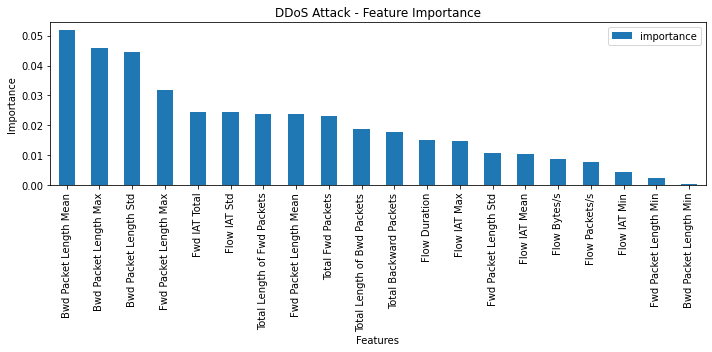

-----------------------------------------------------------------------------------------------




DoS GoldenEye importance list:
DoS GoldenEye 
                              importance
Features                               
Flow IAT Max                   0.075057
Flow Duration                  0.066992
Flow Packets/s                 0.050894
Bwd Packet Length Std          0.048490
Flow IAT Mean                  0.046794
Bwd Packet Length Max          0.039719
Bwd Packet Length Mean         0.024774
Flow IAT Min                   0.022252
Fwd IAT Total                  0.014711
Total Backward Packets         0.013385
Flow IAT Std                   0.011511
Total Length of Bwd Packets    0.008430
Flow Bytes/s                   0.005840
Fwd Packet Length Min          0.005548
Total Fwd Packets              0.005442
Fwd Packet Length Std          0.003294
Fwd Packet Length Max          0.003072
Fwd Packet Length Mean         0.002376
Total Length of Fwd Packets    0.001268
Bwd Packet Le

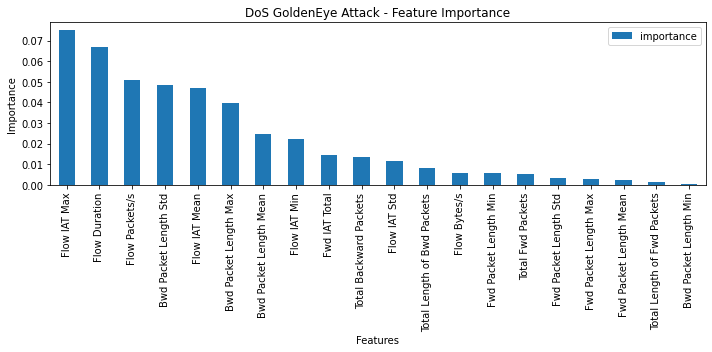

-----------------------------------------------------------------------------------------------




DoS Hulk importance list:
DoS Hulk 
                              importance
Features                               
Bwd Packet Length Std          0.046363
Flow IAT Max                   0.044197
Bwd Packet Length Max          0.040444
Bwd Packet Length Mean         0.038629
Total Length of Bwd Packets    0.020404
Fwd Packet Length Max          0.015566
Total Length of Fwd Packets    0.015192
Fwd Packet Length Mean         0.015177
Flow Duration                  0.015023
Total Backward Packets         0.014488
Flow Bytes/s                   0.013552
Flow IAT Mean                  0.012981
Flow IAT Std                   0.012473
Flow Packets/s                 0.008112
Fwd IAT Total                  0.007819
Fwd Packet Length Std          0.007402
Total Fwd Packets              0.005324
Flow IAT Min                   0.003715
Fwd Packet Length Min          0.002896
Bwd Packet Length Min  

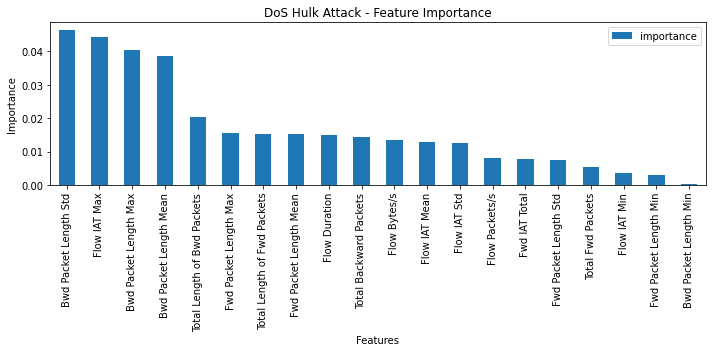

-----------------------------------------------------------------------------------------------




DoS Slowhttptest importance list:
DoS Slowhttptest 
                              importance
Features                               
Flow IAT Max                   0.069858
Flow IAT Mean                  0.069321
Flow IAT Std                   0.052645
Total Length of Bwd Packets    0.024586
Flow Duration                  0.020634
Bwd Packet Length Max          0.019936
Bwd Packet Length Mean         0.017700
Fwd Packet Length Min          0.017600
Flow Packets/s                 0.015940
Fwd IAT Total                  0.015814
Fwd Packet Length Mean         0.015786
Flow IAT Min                   0.015040
Total Backward Packets         0.011566
Bwd Packet Length Std          0.009762
Total Length of Fwd Packets    0.008183
Total Fwd Packets              0.007272
Fwd Packet Length Max          0.007007
Fwd Packet Length Std          0.005812
Flow Bytes/s                   0.003666
Bwd Pac

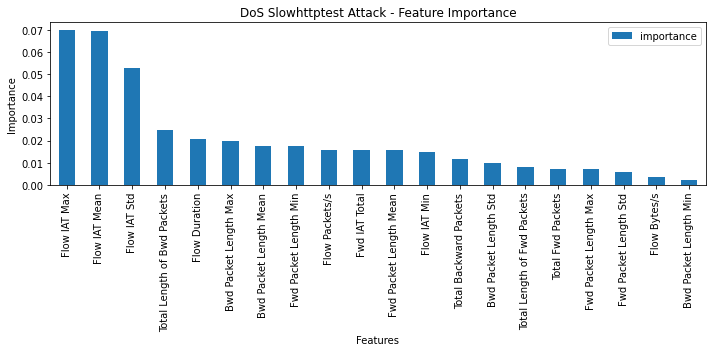

-----------------------------------------------------------------------------------------------




DoS slowloris importance list:
DoS slowloris 
                              importance
Features                               
Bwd Packet Length Mean         0.057210
Flow IAT Mean                  0.052270
Flow Packets/s                 0.050756
Total Length of Bwd Packets    0.040563
Fwd IAT Total                  0.032494
Flow IAT Std                   0.031066
Flow Bytes/s                   0.025274
Flow Duration                  0.025232
Bwd Packet Length Max          0.023109
Flow IAT Max                   0.015388
Fwd Packet Length Max          0.013541
Fwd Packet Length Min          0.011095
Bwd Packet Length Std          0.010266
Flow IAT Min                   0.008885
Fwd Packet Length Mean         0.007891
Total Backward Packets         0.007747
Total Length of Fwd Packets    0.006912
Fwd Packet Length Std          0.004209
Bwd Packet Length Min          0.003182
Total Fwd Pac

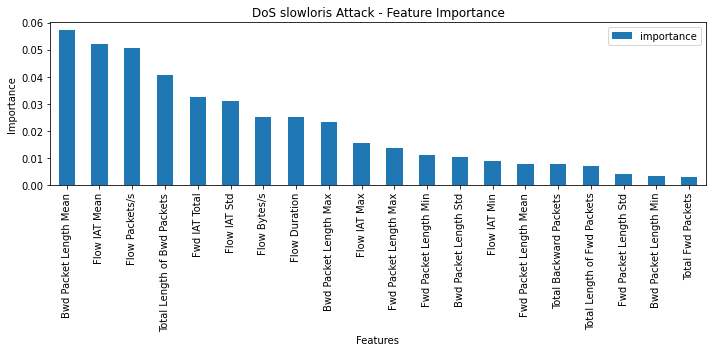

-----------------------------------------------------------------------------------------------




FTP-Patator importance list:
FTP-Patator 
                              importance
Features                               
Fwd Packet Length Std          0.083321
Fwd Packet Length Mean         0.072766
Fwd Packet Length Max          0.052202
Bwd Packet Length Max          0.035980
Total Length of Fwd Packets    0.026953
Bwd Packet Length Mean         0.026853
Total Backward Packets         0.010721
Flow Bytes/s                   0.006464
Bwd Packet Length Min          0.005837
Fwd Packet Length Min          0.004439
Flow IAT Mean                  0.003778
Total Length of Bwd Packets    0.003522
Total Fwd Packets              0.003346
Bwd Packet Length Std          0.002812
Flow IAT Max                   0.001724
Flow Duration                  0.001571
Fwd IAT Total                  0.001216
Flow IAT Std                   0.001201
Flow Packets/s                 0.000899
Flow IAT Min     

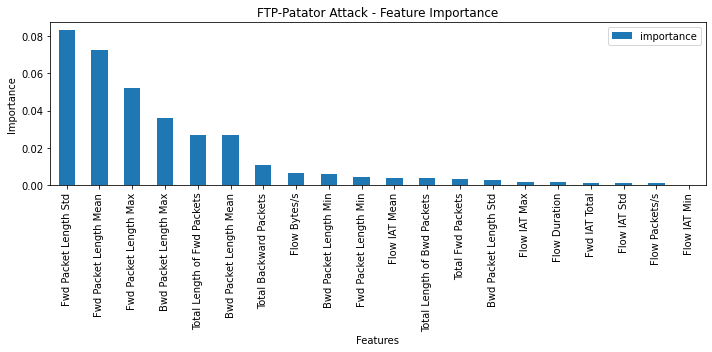

-----------------------------------------------------------------------------------------------




Heartbleed importance list:
Heartbleed 
                              importance
Features                               
Bwd Packet Length Mean         0.049119
Flow IAT Min                   0.040000
Total Length of Bwd Packets    0.037427
Total Backward Packets         0.037119
Fwd IAT Total                  0.036630
Bwd Packet Length Max          0.036000
Total Fwd Packets              0.036000
Flow Duration                  0.019054
Total Length of Fwd Packets    0.016000
Fwd Packet Length Max          0.014063
Bwd Packet Length Std          0.012000
Flow Bytes/s                   0.005690
Fwd Packet Length Std          0.004581
Fwd Packet Length Mean         0.003485
Fwd Packet Length Min          0.000000
Flow Packets/s                 0.000000
Flow IAT Mean                  0.000000
Flow IAT Std                   0.000000
Flow IAT Max                   0.000000
Bwd Packet Length M

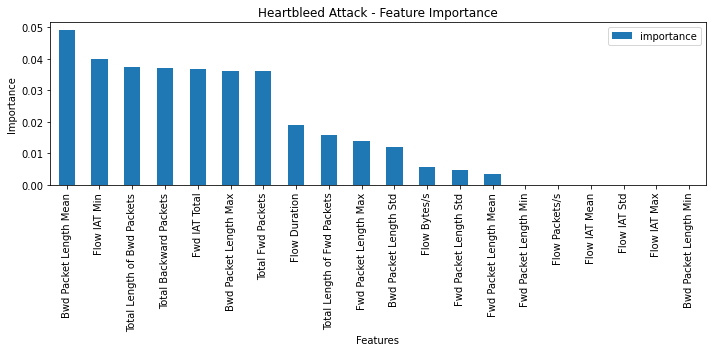

-----------------------------------------------------------------------------------------------




Infiltration importance list:
Infiltration 
                              importance
Features                               
Fwd Packet Length Max          0.068389
Total Length of Fwd Packets    0.060141
Fwd Packet Length Mean         0.054699
Fwd Packet Length Std          0.039265
Flow Duration                  0.038755
Flow IAT Max                   0.036657
Fwd IAT Total                  0.031440
Total Fwd Packets              0.021975
Total Backward Packets         0.016553
Flow IAT Mean                  0.013311
Bwd Packet Length Mean         0.012740
Flow IAT Std                   0.012041
Flow IAT Min                   0.009924
Bwd Packet Length Std          0.009048
Flow Bytes/s                   0.007062
Bwd Packet Length Max          0.006109
Flow Packets/s                 0.006108
Fwd Packet Length Min          0.004129
Bwd Packet Length Min          0.003786
Total Length of

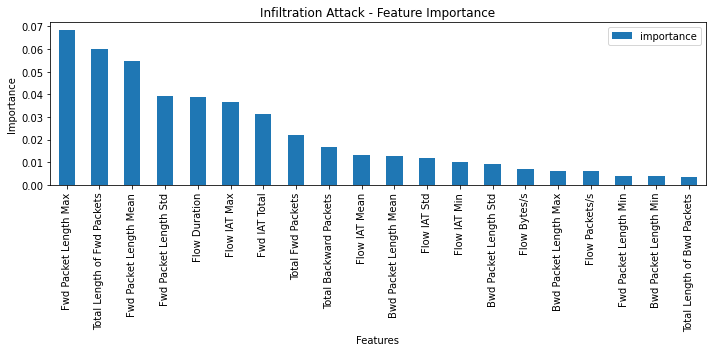

-----------------------------------------------------------------------------------------------




PortScan importance list:
PortScan 
                              importance
Features                               
Fwd Packet Length Max          0.064484
Total Length of Fwd Packets    0.061422
Fwd Packet Length Mean         0.047181
Flow Duration                  0.032356
Bwd Packet Length Min          0.026797
Bwd Packet Length Max          0.025328
Total Length of Bwd Packets    0.024797
Bwd Packet Length Mean         0.019359
Flow Bytes/s                   0.019164
Flow Packets/s                 0.014963
Fwd IAT Total                  0.014897
Flow IAT Max                   0.014125
Total Fwd Packets              0.010560
Flow IAT Mean                  0.005260
Fwd Packet Length Min          0.002922
Flow IAT Std                   0.002650
Total Backward Packets         0.002414
Flow IAT Min                   0.001416
Fwd Packet Length Std          0.000126
Bwd Packet Length Std  

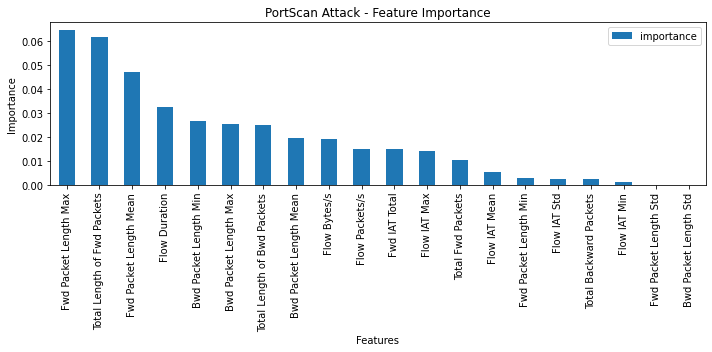

-----------------------------------------------------------------------------------------------




SSH-Patator importance list:
SSH-Patator 
                              importance
Features                               
Flow Bytes/s                   0.051673
Total Backward Packets         0.029402
Total Length of Fwd Packets    0.022117
Flow IAT Max                   0.021033
Fwd Packet Length Min          0.020447
Total Fwd Packets              0.019882
Fwd Packet Length Max          0.018506
Flow Packets/s                 0.013318
Flow IAT Mean                  0.012317
Flow Duration                  0.011931
Flow IAT Std                   0.010209
Fwd Packet Length Mean         0.009725
Fwd IAT Total                  0.009188
Bwd Packet Length Max          0.009090
Bwd Packet Length Mean         0.007539
Flow IAT Min                   0.006268
Total Length of Bwd Packets    0.006061
Bwd Packet Length Std          0.004900
Bwd Packet Length Min          0.004536
Fwd Packet Length

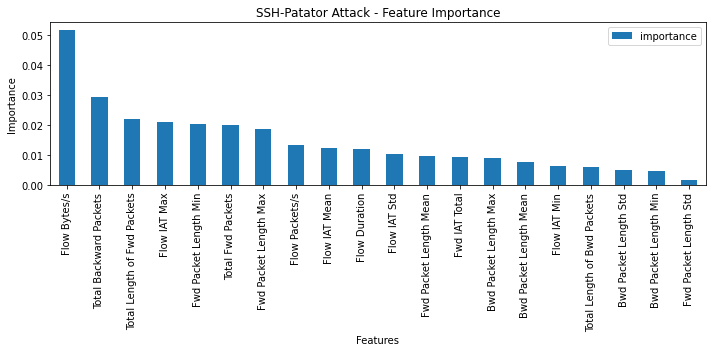

-----------------------------------------------------------------------------------------------




Web Attack importance list:
Web Attack 
                              importance
Features                               
Flow Bytes/s                   0.049065
Total Length of Fwd Packets    0.037857
Fwd Packet Length Max          0.033479
Fwd Packet Length Mean         0.032063
Flow IAT Max                   0.020376
Flow IAT Std                   0.019471
Flow Packets/s                 0.017875
Flow Duration                  0.016630
Flow IAT Mean                  0.014581
Fwd IAT Total                  0.012145
Flow IAT Min                   0.009415
Total Fwd Packets              0.009326
Total Length of Bwd Packets    0.007421
Bwd Packet Length Mean         0.005252
Bwd Packet Length Max          0.004786
Fwd Packet Length Std          0.003554
Total Backward Packets         0.003513
Bwd Packet Length Std          0.002103
Fwd Packet Length Min          0.000194
Bwd Packet Length M

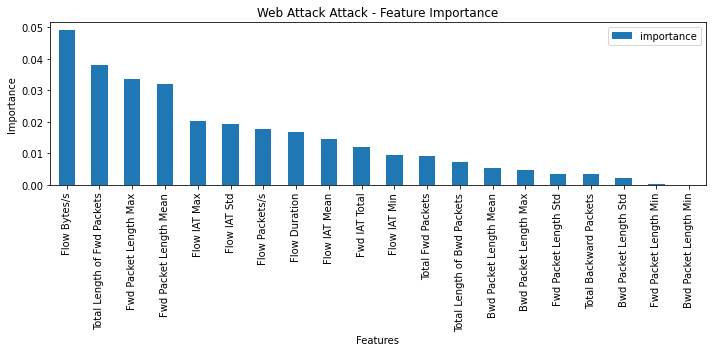

-----------------------------------------------------------------------------------------------




mission accomplished!
Total operation time: =  908.1777262687683 seconds


In [ ]:
#5
## The operation of the program requires an "attack" folder (with an attack CSV file). The Attack folder must be in the same directory as the program
##：The purpose of this code is to determine which features to use during the machine learning phase.
##To do this, calculate the importance weight of the attack.use sklearn-RandomForestRClassifier.

##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn as sk
import time
seconds = time.time()

def folder(f_name): #this function creates a folder named "feaure_pics" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")
        

# CSV files names:
csv_files=os.listdir("attacks")# It creates a list of file names in the "attacks" folder.

# Headers of column
main_labels=["Flow Duration","Total Fwd Packets","Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min","Idle Mean","Idle Std","Idle Max","Idle Min","Label"]


ths = open("importance_list_for_attack_files.csv", "w")
folder("./feaure_pics/")

for j in csv_files:
    df=pd.read_csv(".\\attacks\\"+j,usecols=main_labels)
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]:#It changes the normal tag to "1" and the attack tag to "0" for use in machine learning algorithms.
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    y = df["Label"].values
    del df["Label"]
    X = np.nan_to_num(df.values.astype(np.float32))


    #computing the feature importances
    forest = sk.ensemble.RandomForestClassifier(n_estimators=250,random_state=0)
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    refclasscol=list(df.columns.values)
    impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})
    impor_bars = impor_bars.sort_values('importance',ascending=False).set_index('Features')
    plt.rcParams['figure.figsize'] = (10, 5)
    impor_bars.plot.bar();
    #printing the feature importances  
    count=0
    fea_ture=j[0:-4]+"=["
    for i in impor_bars.index:
        fea_ture=fea_ture+"\""+str(i)+"\","
        count+=1
        if count==5:
            fea_ture=fea_ture[0:-1]+"]"
            break     
    print(j[0:-4],"importance list:")
    print(j[0:-4],"\n",impor_bars.head(20),"\n\n\n")
    print(fea_ture)
    plt.title(j[0:-4]+" Attack - Feature Importance")
    plt.ylabel('Importance')
    plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
    ths.write((  fea_ture ) )
    plt.tight_layout()
    plt.show()
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

    
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")
ths.close()

# Calculate the importance weight of the feature in Total_Attack file and find the most 20 important features of all attacks

In [ ]:
#6
##The operation of the program requires a CSV file. The CSV file must be in the same directory as the program.
## The purpose of this code is to determine which features to use during the machine learning phase.
## To do this, calculate the importance weight of the attack.
##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
import sklearn as sk
import time
seconds = time.time()

def folder(f_name): #this function creates a folder named "feaure_pics" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")
        

# CSV files names:
csv_files=["Total_Attack.csv"]# It creates a list of file names in the "attacks" folder.

# Headers of column
main_labels=["Flow Duration","Total Fwd Packets",   "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min",
    "Idle Mean","Idle Std","Idle Max", "Idle Min","Label"]

ths = open("importance_list_Total_Attack.csv", "w")
folder("./feaure_pics/")
for j in csv_files:
    df=pd.read_csv(j,usecols=main_labels)
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]:#it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    for col in main_labels:
        m = df.loc[df[col] != np.inf, col].max()
        df[col].replace(np.inf,m,inplace=True)

    y = df["Label"].values
    del df["Label"]
    X = df.values
   

    #computing the feature importances
    forest = sk.ensemble.RandomForestClassifier(n_estimators=250,random_state=0)
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    refclasscol=list(df.columns.values)
    impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})
    impor_bars = impor_bars.sort_values('importance',ascending=False).set_index('Features')
    plt.rcParams['figure.figsize'] = (10, 5)
    impor_bars.plot.bar();
    #printing the feature importances  
    count=0
    fea_ture=j[0:-4]+"=["
    for i in impor_bars.index:
        fea_ture=fea_ture+"\""+str(i)+"\","
        count+=1
        if count==5:
            fea_ture=fea_ture[0:-1]+"]"
            break     
    print(j[0:-4],"importance list:")
    print(j[0:-4],"\n",impor_bars.head(20),"\n\n\n")
    print(fea_ture)
    plt.title(j[0:-4]+" Attack - Feature Importance")
    plt.ylabel('Importance')
    plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
    ths.write((  fea_ture ) )
    plt.tight_layout()
    #plt.show()
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")
  
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"secomds")
ths.close()

#7 Build 6 ML Models that I choosed

In [7]:
#7
ml_list={
"NaiveBayes":GaussianNB(),
"DecisionTree":DecisionTreeClassifier(max_depth=5,criterion="entropy"),
"Random Forest":RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
"NearestNeighbors":KNeighborsClassifier(3),
"Perceptron":Perceptron(),
"LinearSVM":Pipeline([("scaler", StandardScaler()),("svm_clf", LinearSVC(C=10, loss="hinge"))]))}
#The machine learning algorithms to be used are defined in a dictionary (ml_list).

#Traning and calculate models


In [6]:
#8
#import the tool library in whole sections
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import pandas as pd
import csv
import time
import warnings
import math
warnings.filterwarnings("ignore")

#Measure the 6 models for each attack file

9 Creat the first 5 of the features for each attack file

In [8]:
#9
# the features to be used for each attack type is defined in a dictionary(features).
# the first 5 of the features created：
features={"Bot":["Bwd Packet Length Mean","Total Length of Bwd Packets","Bwd Packet Length Max","Flow Duration","Total Backward Packets","Label"],
"DDoS":["Bwd Packet Length Mean","Bwd Packet Length Max","Bwd Packet Length Std","Fwd Packet Length Max","Fwd IAT Total","Label"],
"DoS GoldenEye":["Flow IAT Max","Flow Duration","Flow Packets/s","Bwd Packet Length Std","Flow IAT Mean","Label"],
"DoS Hulk":["Bwd Packet Length Std","Flow IAT Max","Bwd Packet Length Max","Bwd Packet Length Mean","Total Length of Bwd Packets","Label"],
"DoS Slowhttptest":["Flow IAT Max","Flow IAT Mean","Flow IAT Std","Total Length of Bwd Packets","Flow Duration","Label"],
"DoS slowloris":["Bwd Packet Length Mean","Flow IAT Mean","Flow Packets/s","Total Length of Bwd Packets","Fwd IAT Total","Label"],
"FTP-Patator":["Fwd Packet Length Std","Fwd Packet Length Mean","Fwd Packet Length Max","Bwd Packet Length Max","Total Length of Fwd Packets","Label"],
"Heartbleed":["Bwd Packet Length Mean","Flow IAT Min","Total Length of Bwd Packets","Total Backward Packets","Fwd IAT Total","Label"],
"Infiltration":["Fwd Packet Length Max","Total Length of Fwd Packets","Fwd Packet Length Mean","Fwd Packet Length Std","Flow Duration","Label"],
"PortScan":["Fwd Packet Length Max","Total Length of Fwd Packets","Fwd Packet Length Mean","Flow Duration","Bwd Packet Length Min","Label"],
"SSH-Patator":["Flow Bytes/s","Total Backward Packets","Total Length of Fwd Packets","Flow IAT Max","Fwd Packet Length Min","Label"],
"Web Attack":["Flow Bytes/s","Total Length of Fwd Packets","Fwd Packet Length Max","Fwd Packet Length Mean","Flow IAT Max","Label"]}

10 Retrieve each attack file and repete 10 times in loop

In [9]:
#10
#retrieve data
csv_files=os.listdir("attacks")# Gets the file name in the attack folder and assigns it to a list (csv_files)。
path=".\\attacks\\"
repetition=10
seconds=time.time()#Time stamp for all processing time

11 Measure the 5 models for each attack file

In [10]:
#11
result="./results/results_each_attack.csv" #a CSV file is named in which the results are saved.
csv_files=os.listdir("attacks")# 获取攻击文件夹中的文件名称并分配给一个列表(csv_files)。
path=".\\attacks\\"
repetition=10

12 Create a folder named "results" in the program directory.

In [11]:
#12
def folder(f_name): #this function creates a folder named "results" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

folder_name="./results/"
folder(folder_name)

13 a CSV file is created to save the results obtained

In [12]:
#13
#a CSV file is created to save the results obtained:
with open(result, "w", newline="",encoding="utf-8") as f:
    wrt = csv.writer(f)
    wrt.writerow(["File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"])

14 This loop runs on the list containing the filenames. Operations are repeated for each attack file

In [13]:
#14
#read each attack file:
for j in csv_files:
    # print output header
    print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % ("File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"))
    a=[]
    feature_list=list(features[j[0:-4]])
    df=pd.read_csv(path+j, usecols=feature_list)

    #Solve the problem of data hollow value and extreme value 
    df=df.fillna(0)
    for col in feature_list:
      m = df.loc[df[col] != np.inf, col].max()
      df[col].replace(np.inf, m, inplace = True)

    #it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm:
    attack_or_not=[]
    for i in df["Label"]: 
        
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)  

    df["Label"]=attack_or_not

    #this section separates the label and the data into two separate pieces, as Label=y Data=X:
    y = df["Label"]  
    del df["Label"]
    feature_list.remove('Label')
    X = df[feature_list]

    #this loop runs on the list containing the machine learning algorithm names:
    for ii in ml_list: 
        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        t_time=[]

        # This loop allows cross-validation and machine learning algorithm to be repeated 10 times:
        for i in range(repetition): 
            second=time.time()#time stamp for processing time

            # cross-validation:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = repetition)
            # data (X) and labels (y) are divided into 2 parts to be sent to the machine learning algorithm (80% train,20% test). 
            # So, in total there are 4 tracks: training data(X_train), training tag (y_train), test data(X_test) and test tag(y_test).

            #machine learing algorithm is applied in this section:
            #choose algorithm from ml_list dictionary 
            clf = ml_list[ii]                                                                        
            clf.fit(X_train, y_train)
            predict =clf.predict(X_test)
        
            #makes "classification report" and assigns the precision, f-measure, and recall values:   
            f_1=f1_score(y_test, predict, average='macro')
            pr=precision_score(y_test, predict, average='macro')
            rc=recall_score(y_test, predict, average='macro')
            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy.append(clf.score(X_test, y_test))
            t_time.append(float((time.time()-second)))

        #the result of the ten repetitions is printed on the screen:
        print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (j[0:-4],ii,str(round(np.mean(accuracy),2)),str(round(np.mean(precision),2)),
                                          str(round(np.mean(recall),2)),str(round(np.mean(f1),2)),str(round(np.mean(t_time),4))))
        
        # all the values found are saved in the opened file.
        with open(result, "a", newline="",encoding="utf-8") as f: 
            wrt = csv.writer(f)
            for i in range(0,len(t_time)):
                wrt.writerow([j[0:-4],ii,accuracy[i],precision[i],recall[i],f1[i],t_time[i]])#file name, algorithm name, precision, recall, f-measure and t_time are writed in CSV file
        a.append(f1)
        
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")

File              ML algorithm       accuracy        Precision       Recall          F1-score        Time           
Bot               NaiveBayes         0.46            0.67            0.62            0.46            0.0102         
Bot               DecisionTree       0.97            0.95            0.97            0.96            0.0126         
Bot               Random Forest      0.97            0.96            0.98            0.97            0.0374         
Bot               NearestNeighbors   0.91            0.89            0.91            0.9             0.0915         
Bot               Perceptron         0.71            0.35            0.5             0.41            0.0126         
Bot               LinearSVM          0.86            0.86            0.8             0.82            0.0659         
File              ML algorithm       accuracy        Precision       Recall          F1-score        Time           
DDoS              NaiveBayes         0.84            0.83       

#Measure the 6 models for Total_Attack **file**

15 The choosing the most 15 important features for Total_Attack.csv

In [9]:
#15
features={"Total_Attack":["Bwd Packet Length Std","Flow Bytes/s","Total Length of Fwd Packets","Fwd Packet Length Std","Flow IAT Std",
"Flow IAT Min","Fwd IAT Total","Flow Duration","Bwd Packet Length Max","Flow IAT Max","Flow IAT Mean","Total Length of Bwd Packets",
"Fwd Packet Length Min","Bwd Packet Length Mean","Flow Packets/s","Label"]}

16 Retrieve data

In [10]:
#16
result="./results/results_total_attack.csv" #a CSV file is named in which the results are saved.
csv_files=["Total_Attack.csv"]# CSV files names: #The names of the dataset files (csv_files).
path=""
repetition=10
seconds=time.time()#time stamp for all processing time

17 This function creates a folder named "results"in the program directory.

In [11]:
#17
def folder(f_name): #this function creates a folder named "results" and "result_graph_1" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

folder_name="./results/"
folder(folder_name)

18 A CSV file is created to save the results obtained.

In [12]:
#18
with open(result, "w", newline="",encoding="utf-8") as f:
    wrt = csv.writer(f)
    wrt.writerow(["File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"])

19 This loop runs on the list containing the filenames. Operations are repeated for Total_Attack file

In [ ]:
#19
for j in csv_files: #this loop runs on the list containing the filenames.Operations are repeated for all attack files
    print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % ("File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"))# print output header   
    feature_list=list(features[j[0:-4]])
    df=pd.read_csv(path+j,usecols=feature_list)#read an attack file.
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]: #it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    for col in feature_list:
      m = df.loc[df[col] != np.inf, col].max()
      df[col].replace(np.inf, m, inplace = True)
    y = df["Label"] #this section separates the label and the data into two separate pieces, as Label=y Data=X 
    del df["Label"]
    feature_list.remove('Label')
    X = df[feature_list]

    
    for ii in ml_list: #this loop runs on the list containing the machine learning algorithm names. Operations are repeated for all the 7 algorithm
        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        t_time=[]
        for i in range(repetition): # This loop allows cross-validation and machine learning algorithm to be repeated 10 times
            second=time.time()#time stamp for processing time

            # cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.20, random_state = repetition)
            #  data (X) and labels (y) are divided into 2 parts to be sent to the machine learning algorithm (80% train,%20 test). 
            #  So, in total there are 4 tracks: training data(X_train), training tag (y_train), test data(X_test) and test tag(y_test).


            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary                                                                          
            clf.fit(X_train, y_train)
            predict =clf.predict(X_test)
        
            #makes "classification report" and assigns the precision, f-measure, and recall values.s.    
            

            f_1=f1_score(y_test, predict, average='macro')
            pr=precision_score(y_test, predict, average='macro')
            rc=recall_score(y_test, predict, average='macro')
            
            
            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy.append(clf.score(X_test, y_test))
            t_time.append(float((time.time()-second)) )



            
        print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (j[0:-4],ii,str(round(np.mean(accuracy),2)),str(round(np.mean(precision),2)), 
            str(round(np.mean(recall),2)),str(round(np.mean(f1),2)),str(round(np.mean(t_time),4))))#the result of the ten repetitions is printed on the screen.

        with open(result, "a", newline="",encoding="utf-8") as f: # all the values found are saved in the opened file.
            wrt = csv.writer(f)
            for i in range(0,len(t_time)):
                wrt.writerow([j[0:-4],ii,accuracy[i],precision[i],recall[i],f1[i],t_time[i]])#file name, algorithm name, precision, recall and f-measure are writed in CSV file

print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")

File              ML algorithm       accuracy        Precision       Recall          F1-score        Time           
Total_Attack      NaiveBayes         0.79            0.64            0.65            0.65            2.5622         
Total_Attack      DecisionTree       0.95            0.97            0.86            0.9             19.7124        
Total_Attack      Random Forest      0.94            0.96            0.83            0.88            16.2721        
Total_Attack      NearestNeighbors   0.97            0.95            0.93            0.94            710.1141       
Total_Attack      Perceptron         0.68            0.59            0.65            0.58            8.3668         
